# Programming Exercise: Function Approximation

## README
We strongly recommend you install `gymnasium>=0.28.1` and `python>=3.10.*`. You can set up a python environment using e.g. [conda](https://docs.conda.io/projects/miniconda/en/latest/) in the terminal
```
conda create -n rl23 python=3.10 gymnasium=0.28.1 notebook -c conda-forge
conda activate rl23
```
The `notebook` package is required for opening and working with this jupyter notebook.
In a terminal with the Python environment active, run
```
jupyter notebook ExerciseD.ipynb
```

If you need help setting up a development environment, please visit the office hour or ask for help in the forum.

In [26]:
# Necessary Imports

from typing import Any, Dict, Callable
from dataclasses import dataclass
from functools import cached_property, partial

import numpy as np
import gymnasium as gym
from gymnasium import spaces

## Submission
**Solve the tasks D1 and D2 below and submit your final `.ipynb` file as a solution to the mCMS.**

During grading, we will clear outputs and then run all cells.
Notebooks that produce runtime errors will be graded with 0 points, unless the errors arise due to gymnasium/numpy backwards compatibility issues.

## Problem statement
The task of the programming exercise is to program an agent that learns to play Tic-Tac-Toe against different opponents. 

## Opponent Policies

We load and initialize the opponent policies of increasing strength from .json-files. They are stored in global variables and can therefore be easily changed at any point of the notebook. The opponent policies are of increasing strength.

For loading the policies, the folder `Opponent_Policies` containing the .json-files of the policies should lie in the same directory as this notebook.  

In [27]:
# Load opponent policy from .json-file. 

import json
from pathlib import Path

opponent_policy_file = Path('Opponent_Policies') # Change filename to play against different policy.

with open(opponent_policy_file / 'policy1.json') as json_file:
    opponent_policy_1 = json.load(json_file)

with open(opponent_policy_file / 'policy2.json') as json_file:
    opponent_policy_2 = json.load(json_file)

with open(opponent_policy_file / 'policy3.json') as json_file:
    opponent_policy_3 = json.load(json_file)

with open(opponent_policy_file / 'policy4.json') as json_file:
    opponent_policy_4 = json.load(json_file)

# Set opponent policy
opponent_policy_dict = opponent_policy_1 # Change to play against different opponent policy.

## Gymnasium Environment for Tic-Tac-Toe

We implement a Gymnasium environment simulating a game of Tic-Tac-Toe. We thereby use
- as possible field values  $V = \{0,1,2\}$, whereby $v = 0$ stands for a 'O'-field, $v = 1$ for an empty field, and $v = 2$ for a 'X'-field.
- as state space $S = V^{3 \times 3}$. A state `s` is stored as a `list[list[int]]`, `s[i][j]` refers then to the value in the i-th row in the j-th column.
- action space $A = V \times V = \{(0,0),(0,1),(0,2),(1,0),(1,1),(1,2), (2,0),(2,1),(2,2)\}$.

### Environment Dynamics

We implement Tic-Tac-Toe as a sequential decision problem. The agent plays against a specified opponent policy (see above). One step of the environment looks as follows: 
1. Perform the move of the agent. The agent marks fields with 'X'.
2. Check whether this has finished the game, i.e. win for the agent or draw. If the game is finished, terminate episode and compute the reward. 
3. Perform the game of the opponent. The opponent marks fields with 'O'.
4. Check whether this has finished the game, i.e. win for the opponent or draw. If the game is finished, terminate episode and compute the reward. 

#### Initial state
We randomize whether the agent or the opponent starts with the first move. Hence, the initial state of the sequential decision problem is either
- a completely empty field, for the case that the agent has the first move, or
- a field with one '0', for the case that the opponent has the first move. 


#### Rewards
Rewards are only gained when the game is finished: 
- Reward of 1, if the agent wins. 
- Reward of 0, if the game ends in a draw. 
- Reward of -1, if the opponent wins. 

#### Executable Actions 
Notice that not all actions are always executable: If a field `s[i][j]` is non-empty, then the action $(i,j)$ is not executable. If the agent tries to perform a non-executable action, the environment raises an Exception. Hence, make sure that the agent only picks executable actions (the opponent policy chooses only executable actions as well).

In [28]:
# Some preliminary and auxiliary definitions 

# Definitions of possible field values
CROSS, EMPTY, CIRCLE = 2, 1, 0  

def get_rows(state: list[list[int]]) -> [list[list[int]], list[list[int]], list[list[int]]]:
    """
    Helper function: Returns list of rows, list of columns, and list of diagonals
    
    """

    # Compute rows
    rows = state

    # Compute columns
    columns = []
    for j in range(3):
        column = []
        for i in range(3):
            column.append(state[i][j])
        columns.append(column)
    
    #Compute diagonals
    diagonal0 = []
    diagonal1 = []
    for i in range(3):
        diagonal0.append(state[i][i])
        diagonal1.append(state[2-i][i])
    
    # Return rows, columns, and diagonals. 
    return rows, columns, [diagonal0, diagonal1]

# Gymnasium environment for Tic-Tac-Toe
class SysadminEnv(gym.Env):

    def __init__(
        self,
    ) -> None:
        
        super().__init__()
        self.action_space = spaces.MultiDiscrete([3,3]) # Action space 
        self.observation_space = spaces.MultiDiscrete([[3,3,3],[3,3,3],[3,3,3]]) # State space
        self.reset_counter = 0


    @property
    def get_reset_counter(self):
        return self.reset_counter
    

    @property
    def occupied_fields(self) -> int | None:
        """
        Returns the number of occupied fields.

        """
        if not hasattr(self, "_state"):
            return None
        
        res = 0
        for l in self._state:
            for v in l:
                if v != EMPTY:
                    res = res + 1
            
        return res
    
    
    @property
    def game_finished(self) -> int | None:
        """
        Returns None if game is not finished.

        Returns 0 if circle wins.
        Returns 1 if it is a draw.
        Returns 2 if crosses wins. 

        """
        rows, columns, diagonals = get_rows(self._state)

        for l in rows + columns + diagonals:
            if all(v == CROSS for v in l):
                return 2
            if all(v == CIRCLE for v in l):
                return 0
            
        if self.occupied_fields == 9:
            return 1
        else:
            return None
        
    
    def opponent_policy (self) -> [int,int]:
        """
            Takes random action from the list of moves of the opponent policy.
        """

        if not hasattr(self, "_state"):
            raise Exception("Unable to find opponent move in uninitialized environment.")
        
        opponent_action_list = opponent_policy_dict[self._state.__str__()]
        return opponent_action_list[np.random.choice(len(opponent_action_list))]

    
    def perform_move(self, move: [int, int], cross: bool):
        """
        Returns the number of occupied fields.

        """
        if not hasattr(self, "_state"):
            raise Exception("Unable to perform move in uninitialized environment.")

        if self._state[move[0]][move[1]] != EMPTY:
            raise Exception("Unable to perform move on occupied field.")
        
        if cross: 
            self._state[move[0]][move[1]] = 2
        else:
            self._state[move[0]][move[1]] = 0

        
    def reset(
        self, *, seed: int | None = None, options: dict[str, Any] | None = None
    ) -> tuple[np.ndarray, dict[str, Any]]:
        """
        Resets the environment to its initial state.
        
        """
        
        super().reset(seed=seed)

        # increment reset_counter
        self.reset_counter += 1

        # All fields are empty initially
        self._state = [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

        # Random choice whether agent or opponent makes the first move. 
        # In case of opponent, first move of opponent is performed.
        if np.random.random() < 0.5:   
            self.perform_move(self.opponent_policy(), False)
        
        return self._state, dict()
   

    def step(self, action: [int,int]) -> tuple[np.ndarray, float, bool, bool, dict[str, Any]]:
        """
        Performs a step in the environment given an action of the agent.

        Return: new_state, reward, done, truncated, information_dictionary (last two return values are irrelevant for our purposes)  

        """
        
        # Perform agent's move
        self.perform_move(action, True)

        # Check whether game is finished and compute the return
        finished = self.game_finished  
        if self.game_finished == 2:
            return self._state, 1, True, False, dict()
        if self.game_finished == 1:
            return self._state, 0, True, False, dict()



        # Perform opponent's move
        self.perform_move(self.opponent_policy(), False)

        # Check whether game is finished and compute the return
        finished = self.game_finished  
        if finished is None:
            return self._state, 0, False, False, dict()
        elif finished == 0:
            return self._state, -1, True, False, dict()
        elif finished == 1:
            return self._state, 0, True, False, dict()    



    def display(self):
        """
        Prints the current state of the field to the command line. 

        """

        if not hasattr(self, "_state"):
           raise Exception("Unable to visualize uninitialized environment.")
       
        res = [["","",""],["","",""],["","",""]] 

        for i in range(3):
            for j in range(3):
                v = self._state[i][j]
                if v == CROSS:
                    res[i][j] = "X"
                elif v == EMPTY:
                    res[i][j] = " "
                elif v == CIRCLE:
                    res[i][j] = "O"
                else: 
                    raise Exception("Invalid value in TicTacToe Field")

        for l in res: 
            print(l)
    
        print("\n")



In [29]:
# Register environment
gym.register("Sysadmin-ED", partial(SysadminEnv))
env = gym.make("Sysadmin-ED")

C:\Users\behka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment Sysadmin-ED already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [30]:
# Example on how to experiment with the environment. 

env.reset(seed=42)
env.display() 
#print(env.step((1,2)))
"""next_state, reward, done, truncated,_ = env.step((0,2))
env.display()
if done:
    print("Game is finished")
    print("--------------------------------------")
else:
    print("Game is not finished")
    print("--------------------------------------")"""

[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']




C:\Users\behka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\utils\passive_env_checker.py:140: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(f"{pre} was expecting a numpy array, actual type: {type(obs)}")
C:\Users\behka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.display to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.display` for environment variables or `env.get_wrapper_attr('display')` that will search the reminding wrappers.
  logger.warn(


'next_state, reward, done, truncated,_ = env.step((0,2))\nenv.display()\nif done:\n    print("Game is finished")\n    print("--------------------------------------")\nelse:\n    print("Game is not finished")\n    print("--------------------------------------")'

## Exercise D.1 (2 Points)

Briefly describe the learning algorithm you have implemented. When using function approximation, describe in particular the features that you are using. 

TODO:

Three functions are also added besides agent_policy and training_algorithm. All functions are described below:

1. allowed_actions:
   It gets the state as input and calculates the cells that are empty and returns them as allowed actions in that state.
   
2. extract_features:
   It gets state and action and returns features. Features are described below:

   Feature 0 : Bias of 1 for w0 (offset).

   Feature 1 to 9: For each cell in the state space, it appends the value of that cell to the features in order (starting from [0, 0], [0, 1], ..., [2, 1], [2, 2]) and normalized. (Since a value a cell can get is in the range of 0 to 2 all of the values are divided by 2 before being appended to the features.)

   This feature contains features for center, corners, and sides.

   Feature 10: Appends the number of rows, columns, and diagonals with Two O's and no X.(Since this number can be in the range of 0 to 4, in the real game scenario, the value is divided by 4 before being appended to the features.)

   Features 11 to 19: Actions are appended to the features. The value of 1 is appended for the action that is chosen and 0 is appended for other actions.

   Up to this point there are a total of 20 features (starting from 0 to 19)!
   
   Polynomial Features: Polynomial features are also appended to the array of features. Therefore, the number of features is 20 + (20*20) = 420.

4. approximte_values:
   Gets state, action, and weights. Gets the features using extract_features function and returns dot product of weights and features. This function uses $\hat{q}(S_{t}, A_{t}, w)$ instead of $\hat{v}(S_{t}, w)$.

5. agent_policy:
   Gets current state, weights, and epsilon. Returns action.

   First of all the set of allowed actions is extracted from the allowed_actions function.

   After that the $\epsilon$-greedy method is used for selecting the action. A random number between 0 and 1 is generated, then if this number is less that epsilon, a random action will be chosen. And if random number is equal or greater than epsilon, the best action (the action with the highest approximated value) is chosen greedily.

6. training_algorithm:
   For each episode:

   First the action for the current episode is extracted using the agent_policy.
   
   Then, next_state, reward and the status is extracted using the action applied to the step function.

   Since, the TD(0) method is used to calculate the target for the $\Delta W$, we need the approximated value for the next state ($\hat{q}(S_{t+1}, A_{t+1}, w)$). In order to calculate that, we need to select an action for the next state at this point.

   If the game has not finished yet, the action is selected fully greedy (epsilon = 0) and then the target is calculated using the $target = R_{t+1} + \gamma \hat{q}(S_{t+1}, A_{t+1}, w)$ formula. If the game is done then the target is $R_{t+1}$ since no successor state is available anymore.

   Then, the features are extracted using extract_features function and $\Delta W$ is calculated using the $\Delta W = \alpha * (target - \hat{q}(S_{t}, A_{t}, w))* features$.

   Finally, weights are updated and instead of calculating the expected value each time and updating weights, which will lead to high variance, the expected value (mean) is updated once in 20 steps. (the mini-batch SGD method.)

--------------------------------------------------------------------------------------------------------------------------------------------------------
Extra:

In the last cell we have implemented the code for comparing different average returns with different learning rates and epsilons. We have commented the whole cell so it does not impact the main code. If you want to run it please comment the whole cell before it.

We wanted the average returns near to the true mean and the error to be halved, therefore, we multiplied the test runs by 4 and experimented for 20 test runs.

1. 20 test runs, each 5000 episodes, epsilon = [0, 0.02, 0.05, 0.1, 0.2, 0.5, 1], and learning_rate = 0.05 (against policy = 3)

   It means that when epsilon is in the range 0 to 0.05, the results are relatively good with a peak of approximately 0.4 at epsilon = 0.02
   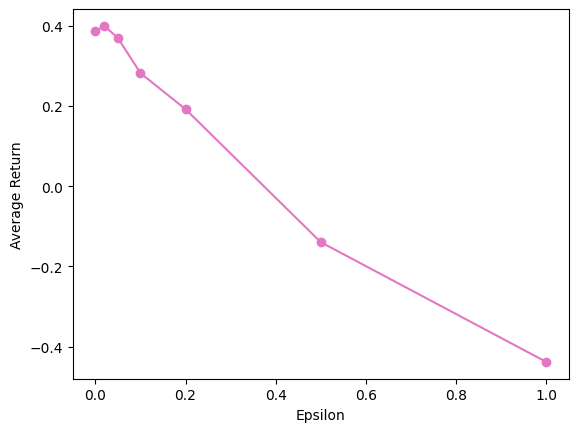

2. 20 test runs, each 5000 episodes, epsilon = 0.02, and learning_rate = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] (against policy = 3)

   It means that when learning_rate is in the range 0 to 0.1, the results are relatively good with a peak of approximately 0.4 at learning_rate = 0.05
   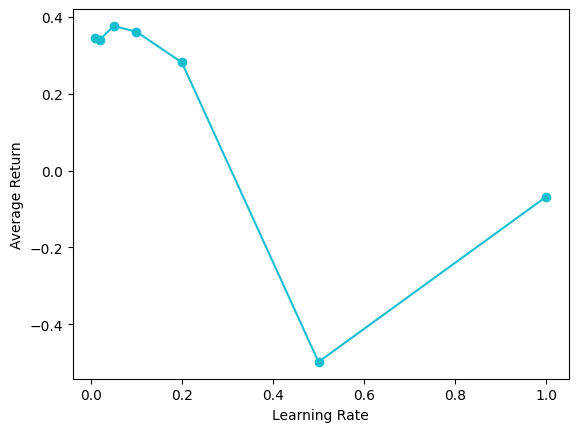

3. 20 test runs, each 5000 episodes, epsilon = [0, 0.02, 0.05, 0.1], and learning_rate = [0.01, 0.02, 0.05, 0.1] (against policy = 3)
   It can be seen that epsilon = 0.1 has the worst results and epsilon = 0 and epsilon = 0.02 were better than the rest in average. However there's a peak at epsilon = 0.05 and Learning_rate = 0.02.
   
   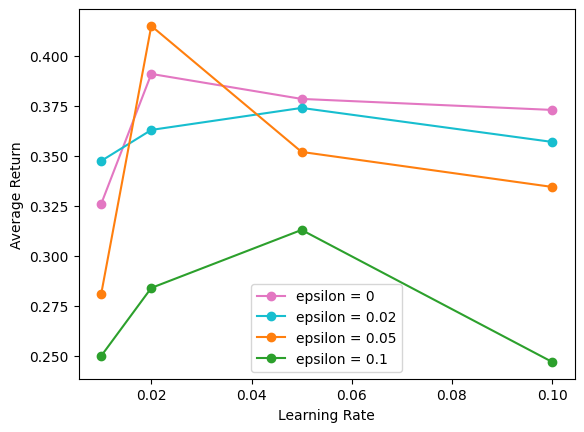



## Exercise D.2 (2+2+2+2+4* Points)

Implement a learning algorithm that learns to play Tic-Tac-Toe. For function approximation learning, the function `RL_algorithm` should return the learned feature weights.

In the case that you are not using function approximation but a different RL algorithm, the arguments and return types of the functions below are allowed to be changed.

In [31]:
gamma = 1
CROSS, EMPTY, CIRCLE = 2, 1, 0  

# Returns a set of allowed actions for each state (allowed actions are the cells that are empty)
def allowed_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j] == EMPTY:
                actions.append([i,j])
    return actions


def extract_features(state, action):
    features = list()

    # Feature0: Offset (w0)
    features.append(1) 

    # Feature 1-9:  Value of each cell of the state space (normalized)
    for i in range(3):
        for j in range(3):
            features.append(state[i][j]/2)
    
    # Feature 10: Number of rows/columns/diagonals with Two O's and no X (normalized)
    rows, columns, diagonals = get_rows(state)
    two_O_counter = 0
    for row in rows + columns + diagonals:
        if row.count(CIRCLE) == 2 and row.count(EMPTY) == 1:
            two_O_counter += 1/4

    features.append(two_O_counter)


    # Feature 11-19: Adding actions to the features 
    for i in range(len(state)):
        for j in range(len(state)):
            if i == action[0] and j == action[1]:
                features.append(1)
            else:
                features.append(0)

    # Polynomial features
    polynomial_features = features.copy()
    for i in range(len(features)):
        for j in range(len(features)):
            polynomial_features.append(features[i]*features[j])

    return np.array(polynomial_features)

    
def approximate_values(state, action, weights):
    features = extract_features(state, action)
    return np.dot(weights, features)

    
def agent_policy(state, weights, epsilon):
    """
    Policy of the agent: Given the environment state and feature weights, returns the best estimated performable action. 

    """
    # Epsilon-greedy for choosing next action 
    all_allowed_actions = allowed_actions(state)
    if np.random.rand() < epsilon:
        # Exploration (randomly choosing)
        if len(all_allowed_actions) > 1:
            random_action_index = np.random.randint(0, len(all_allowed_actions)-1) 
        else:
            random_action_index = 0
        best_action = all_allowed_actions[random_action_index]
    else:
        # Exploitation (greedily choosing)
        max_approximate_value = None
        best_action = []
        for act in all_allowed_actions:
            act_approximate_value = approximate_values(state, act, weights)
            if (max_approximate_value is None) or (act_approximate_value > max_approximate_value):
                max_approximate_value = act_approximate_value
                best_action = act
    return best_action
        


def training_algorithm(num_episodes: int, epsilon, learning_rate):
    """
    Reinforcement learning algorithm: For function approximation learning, learn the feature weights for the given number of training episodes, i.e. env.reset() is allowed to be called num_episodes many times. 
    
    Returns the learned feature weights. 

    """

    # hyperparameters ---------------------------------------------------------------------------------------------------------
    num_features = 1 + 10 + 9 + (20*20) # Feature 0 (offset) + Feature 1-10 + Feature 11-19 (actions) + Polynomial features
    weights = np.zeros(num_features) # Initializing weights with zeros
    weights[0] = 1 # bias 
    min_batch_size = 20 # for updating weights
    cumulative_gradients = np.zeros_like(weights)
    update_count = 0
    # -------------------------------------------------------------------------------------------------------------------------
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        truncated = False
        while not (done or truncated):

            action = agent_policy(state, weights, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            if not (done or truncated):
                # fully greedy (epsilon = 0) -----------------------------------------------------------------------------------------------
                best_action = agent_policy(next_state, weights, 0)
                target = reward + gamma * approximate_values(next_state, best_action, weights) # target for TD(0) Learning
            else:
                target = reward # when the game is finished 
            
            # extract features and compute gradients -------------------------------------------------------------------------
            features = extract_features(state, action)
            gradients = learning_rate * (target - approximate_values(state, action, weights)) * features 
            cumulative_gradients += gradients # cumulative gradients for updating weights once in each 20 steps

            # compute weights ------------------------------------------------------------------------------------------------
            update_count += 1
            if update_count % min_batch_size == 0:
                weights += cumulative_gradients / min_batch_size
                cumulative_gradients = np.zeros_like(weights)
            state = next_state
    return weights

## Policy Evaluation 

We evaluate the learned polices multiple times against the different opponent policies using the script below.  

In [32]:
def evaluate_policy(weights, eval_episodes: int, epsilon):
    # Evaluates the agent's policy described by the learned weights by simulating the given number of episodes. 
    # Returns the overall number of wins, draws, looses, and the statistical mean of the episode returns.


    returns = []
    wins, draws, looses = 0,0,0

    for episode in range(eval_episodes):
        
        state = env.reset()[0]
        done = False
        
        while not done:
            action = agent_policy(state, weights, epsilon)
            _, reward, done, _,_ = env.step(action)
            if done: 
                if reward == 1: 
                    wins = wins + 1
                elif reward == 0:
                    draws = draws + 1
                elif reward == -1:
                    looses = looses + 1

                returns.append(reward)  
          
    return wins, draws, looses, np.mean(returns)


opponent_policy_dict = opponent_policy_4 # Change to play against different opponent policy.

# Policy testing
training_episodes = 5000 # Number of training episodes
test_episodes = 100 # Number of test episodes
test_runs = 5 # Number of test runs


for i in range (test_runs):
    env = gym.make("Sysadmin-ED") 
    epsilon = 0.02
    learning_rate = 0.05
    weights = training_algorithm(training_episodes, epsilon, learning_rate) # learn the weights via function approximation learning
    
    # Check that number of episodes is not exceeded
    if env.get_reset_counter > training_episodes:
        raise RuntimeError(f"Exceeded maximal number of calls of reset function")
    
    wins, draws, looses, average_return = evaluate_policy(weights, test_episodes, epsilon) # evaluate the learned policy
    print(f"Training iteration {i}: Wins: {wins}, Draws: {draws}, Looses: {looses}, Average Return: {average_return}") # print results of the current test run



C:\Users\behka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\utils\passive_env_checker.py:140: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(f"{pre} was expecting a numpy array, actual type: {type(obs)}")


C:\Users\behka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_reset_counter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_reset_counter` for environment variables or `env.get_wrapper_attr('get_reset_counter')` that will search the reminding wrappers.
  logger.warn(


Training iteration 0: Wins: 56, Draws: 0, Looses: 44, Average Return: 0.12
Training iteration 1: Wins: 58, Draws: 0, Looses: 42, Average Return: 0.16
Training iteration 2: Wins: 44, Draws: 2, Looses: 54, Average Return: -0.1
Training iteration 3: Wins: 46, Draws: 3, Looses: 51, Average Return: -0.05
Training iteration 4: Wins: 57, Draws: 0, Looses: 43, Average Return: 0.14


In [33]:
'''
import matplotlib.pyplot as plt
def evaluate_policy(weights, eval_episodes: int, epsilon):
    returns = []
    wins, draws, looses = 0,0,0

    for episode in range(eval_episodes):
        
        state = env.reset()[0]
        done = False
        
        while not done:
            action = agent_policy(state, weights, epsilon)
            _, reward, done, _,_ = env.step(action)
            if done: 
                if reward == 1: 
                    wins = wins + 1
                elif reward == 0:
                    draws = draws + 1
                elif reward == -1:
                    looses = looses + 1

                returns.append(reward)  
          
    return wins, draws, looses, np.mean(returns)


opponent_policy_dict = opponent_policy_3 # Change to play against different opponent policy.

# Policy testing
training_episodes = 5000 # Number of training episodes
test_episodes = 100 # Number of test episodes
test_runs = 20 # Number of test runs

epsilon = [0, 0.02, 0.05, 0.1]
learning_rate = [0.01, 0.02, 0.05, 0.1]
average_return_for_epsilons = []


for e in epsilon:
    average_return_per_learning_rate = []
    print(f"epsilon: {e}")

    for alpha in learning_rate:
        print(f"learning rate: {alpha}")
        returns = []
        for i in range (test_runs):
            env = gym.make("Sysadmin-ED") 
            weights = training_algorithm(training_episodes, e, alpha) # learn the weights via function approximation learning
        
            # Check that number of episodes is not exceeded
            if env.get_reset_counter > training_episodes:
                raise RuntimeError(f"Exceeded maximal number of calls of reset function")
        
            wins, draws, looses, average_return = evaluate_policy(weights, test_episodes, e) # evaluate the learned policy
            print(f"Training iteration {i}: Wins: {wins}, Draws: {draws}, Looses: {looses}, Average Return: {average_return}") # print results of the current test run
            returns.append(average_return)
        print()
        print(f"average return for learning rate: {alpha} after {test_runs} test runs: {sum(returns)/test_runs}")
        average_return_per_learning_rate.append(sum(returns)/test_runs)
        print("---------------------------------------------------------------------------------------")
    print("Next epsilon")
    average_return_for_epsilons.append(average_return_per_learning_rate)
    print("---------------------------------------------------------------------------------------")
    

xpoints = learning_rate  
ypoints = average_return_for_epsilons[0]
plt.plot(xpoints, ypoints, marker = 'o', color="tab:pink")

ypoints = average_return_for_epsilons[1]
plt.plot(xpoints, ypoints, marker = 'o', color="tab:cyan")

ypoints = average_return_for_epsilons[2]
plt.plot(xpoints, ypoints, marker = 'o', color="tab:orange")

ypoints = average_return_for_epsilons[3]
plt.plot(xpoints, ypoints, marker = 'o', color="tab:green")

plt.xlabel("Learning Rate")
plt.ylabel("Average Return")

plt.legend(["epsilon = 0", "epsilon = 0.02", "epsilon = 0.05", "epsilon = 0.1"])
plt.show()
'''

'\nimport matplotlib.pyplot as plt\ndef evaluate_policy(weights, eval_episodes: int, epsilon):\n    returns = []\n    wins, draws, looses = 0,0,0\n\n    for episode in range(eval_episodes):\n        \n        state = env.reset()[0]\n        done = False\n        \n        while not done:\n            action = agent_policy(state, weights, epsilon)\n            _, reward, done, _,_ = env.step(action)\n            if done: \n                if reward == 1: \n                    wins = wins + 1\n                elif reward == 0:\n                    draws = draws + 1\n                elif reward == -1:\n                    looses = looses + 1\n\n                returns.append(reward)  \n          \n    return wins, draws, looses, np.mean(returns)\n\n\nopponent_policy_dict = opponent_policy_3 # Change to play against different opponent policy.\n\n# Policy testing\ntraining_episodes = 5000 # Number of training episodes\ntest_episodes = 100 # Number of test episodes\ntest_runs = 20 # Number o